In [43]:
from matplotlib import pyplot as plt
import numpy as np

In [44]:
def load_images(filename):
    images = np.fromfile(path_to_images, dtype=np.uint8, count= -1)[16:]
    return images

def reshape_images(images):
    return images.reshape(-1, 28, 28)

def load_labels(filename):
    labels = np.fromfile(path_to_labels, dtype=np.uint8, count=-1)[8:]
    return labels

Тренировочная выборка:  (60000, 28, 28) , метки:  (60000,)
Тестовая выборка:  (10000, 28, 28) , метки:  (10000,)


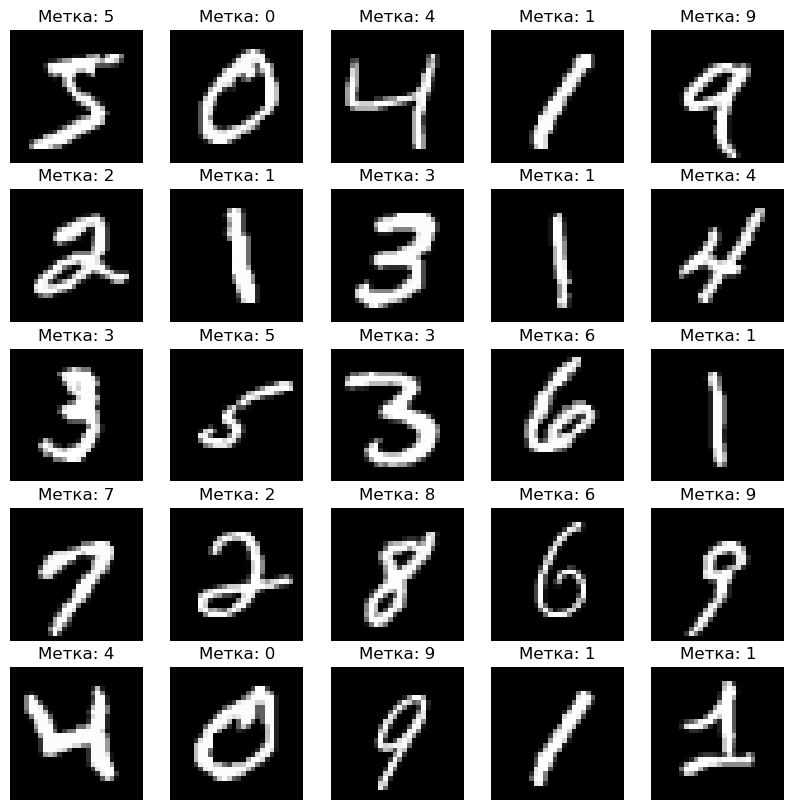

In [45]:
train_images = load_mnist_images('data/train-images-idx3-ubyte/train-images-idx3-ubyte')
train_labels = load_mnist_labels('data/train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images = load_mnist_images('data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels = load_mnist_labels('data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')
print("Тренировочная выборка: ", train_images.shape, ", метки: ", train_labels.shape)
print("Тестовая выборка: ", test_images.shape, ", метки: ", test_labels.shape)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)  
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f'Метка: {train_labels[i]}')  
    plt.axis('off')

plt.show()

In [46]:
def ReLU(x):
    return np.maximum(0, x)

def diff_ReLU(x):
    return np.array(x>=0, dtype=np.int8)

def softmax(x):
    e_x = np.exp(x - np.max(x, axis = 1, keepdims = True))
    return e_x / np.sum(e_x, axis = 1, keepdims = True)
    
def cross_entropy(y_pred, y_true):
    epsilon = 1e-15  
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    batch_size = y_pred.shape[0]
    res = np.log(1 - y_pred)
    res[range(batch_size), y_true.flatten()] = np.log(y_pred)[range(batch_size), y_true.flatten()]
    return -np.sum(res) / batch_size

def accuracy(y_pred, y_true):
    y_pred = np.argmax(y_pred, axis=1)
    return np.sum(y_pred == y_true) / y_true.size

In [47]:
class DeepNeuralNetwork:
    def __init__(self, hidden_size, input_size = 28*28, output_size = 10):
        self.hidden_neurons_count = hidden_size
        self.input_neurons_count = input_size
        self.output_neurons_count = output_size
        
        self.W = np.random.randn(self.input_neurons_count, self.hidden_neurons_count) * np.sqrt(2.0/self.input_neurons_count)
        self.w = np.zeros((1, self.hidden_neurons_count))
        
        self.V = np.random.randn(self.hidden_neurons_count, self.output_neurons_count) * np.sqrt(2.0/self.hidden_neurons_count)
        self.v = np.zeros((1, self.output_neurons_count))
    
    def predict(self, x):
        self.forward_pass(x)
        return self.g
        
    def fit(self, x, y, lr):
        self.forward_pass(x)
        self.backward_pass(x, y)
        self.step(lr)
        return self.g
    
    def forward_pass(self, x):
        self.param_s = x @ self.W + self.w
        self.param_z = ReLU(self.param_s)
        self.delta_relu = diff_ReLU(self.param_s)
        
        self.param_t = self.param_z @ self.V + self.v
        self.g = softmax(self.param_t)
        
    def backward_pass(self, x, y):
        batch_size = x.shape[0]
        
        self.delta_t = np.copy(self.g)
        self.delta_t[range(batch_size), y.flatten()] -= 1
        
        self.dV = self.param_z.T @ self.delta_t
        self.dv = np.sum(self.delta_t, axis=0, keepdims=True)
        
        self.delta_z = self.delta_t @ self.V.T
        self.delta_s = self.delta_z * self.delta_relu
        
        self.dW = x.T @ self.delta_s 
        self.dw = np.sum(self.delta_s, axis=0, keepdims=True)

    
    def step(self, lr):
        batch_size = self.g.shape[1]
        theta = lr / batch_size
        
        self.W -= theta * self.dW
        self.w -= theta * self.dw
        self.V -= theta * self.dV
        self.v -= theta * self.dv

In [48]:
hidden_size = 300  
learning_rate = 0.1
epochs = 20
batch_size = 32

model = DeepNeuralNetwork(hidden_size)

def train(model, x_train, y_train, epochs, batch_size, learning_rate):
    for epoch in range(epochs):
        # shuffle
        # print(epoch)
        idx = np.random.permutation(len(y_train))
        x_train_perm = x_train[idx]
        y_train_perm = y_train[idx]
        
        batch_loss = []
        batch_accuracy = []
        for i in range(0, x_train.shape[0], batch_size):
            x_batch = x_train_perm[i:i + batch_size]
            x_batch = x_batch.reshape(-1, 28 * 28)
            
            y_batch = y_train_perm[i:i + batch_size]
            y_batch = y_batch.reshape(batch_size, -1)

            output = model.fit(x_batch, y_batch, learning_rate)
            batch_loss.append(cross_entropy(output, y_batch.flatten()))
            batch_accuracy.append(accuracy(output, y_batch.flatten()))
            
        predictions = model.predict(x_train.reshape(-1, 28 * 28))
        loss = cross_entropy(predictions, y_train.flatten())
        _accuracy = accuracy(predictions, y_train.flatten())

        print(f'Epoch №{epoch + 1}/{epochs}, Loss: {loss}, Accuracy: {_accuracy}')

def test(model, x_test, y_test):
    x_test = x_test.reshape(-1, 28 * 28)
    predictions = model.predict(x_test)
    loss = cross_entropy(predictions, y_test.flatten())
    _accuracy = accuracy(predictions, y_test.flatten())
    
    print(f'Test Loss: {loss}, Test Accuracy: {_accuracy}')

In [49]:
train(model, train_images, train_labels, epochs, batch_size, learning_rate)

Epoch №1/20, Loss: 0.17478828370837865, Accuracy: 0.9710666666666666
Epoch №2/20, Loss: 0.1076761970083343, Accuracy: 0.9819
Epoch №3/20, Loss: 0.08405327971794886, Accuracy: 0.9859666666666667
Epoch №4/20, Loss: 0.05286158807884734, Accuracy: 0.9918666666666667
Epoch №5/20, Loss: 0.04140853566280785, Accuracy: 0.9936
Epoch №6/20, Loss: 0.03177622741173782, Accuracy: 0.9954333333333333
Epoch №7/20, Loss: 0.020652829827008234, Accuracy: 0.9972833333333333
Epoch №8/20, Loss: 0.02304761592168888, Accuracy: 0.9967833333333334
Epoch №9/20, Loss: 0.009295833163921066, Accuracy: 0.9992833333333333
Epoch №10/20, Loss: 0.007659917628329782, Accuracy: 0.9993666666666666
Epoch №11/20, Loss: 0.004717572216240797, Accuracy: 0.9998666666666667
Epoch №12/20, Loss: 0.002856273605937332, Accuracy: 0.9999166666666667
Epoch №13/20, Loss: 0.002118588606029056, Accuracy: 1.0
Epoch №14/20, Loss: 0.0018014603687336922, Accuracy: 1.0
Epoch №15/20, Loss: 0.002211204244319916, Accuracy: 0.9999333333333333
Epoch

In [50]:
test(model, test_images, test_labels)

Test Loss: 0.11374103388831, Test Accuracy: 0.9843
